# Final Project

## Blake Conrad

## TSP Subtour Elimination Via Cutting Planes

In [28]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import itertools

os.chdir(r"C:\Users\blakeconrad\Desktop\imse884\term_project")
df = pd.read_csv("Nfldata.csv")
df = df.iloc[:,1:].iloc[:16,:16]
print(df.shape)
df

(16, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,1270,396,189,739,480,364,554,805,1023,941,1617,1753,2581,1237,2682
1,1270,0,1201,1104,972,1024,960,1094,1028,329,820,967,1710,2258,1246,2571
2,396,1201,0,294,395,183,287,185,440,893,632,1306,1357,2189,851,2287
3,189,1104,294,0,571,315,176,409,644,843,759,1433,1616,2431,1085,2556
4,739,972,395,571,0,259,428,211,88,643,244,910,1072,1866,526,2021
5,480,1024,183,315,259,0,200,115,329,712,472,1152,1305,2116,770,2249
6,364,960,287,176,428,200,0,314,509,680,593,1261,1495,2294,953,2442
7,554,1094,185,409,211,115,314,0,257,772,452,1121,1207,2028,682,2148
8,805,1028,440,644,88,329,509,257,0,700,248,878,987,1788,444,1935
9,1023,329,893,843,643,712,680,772,700,0,502,829,1453,2085,953,2356


# Solve TSP

## Relaxed, allow subtours

    model; returning a clone of the current model instance.


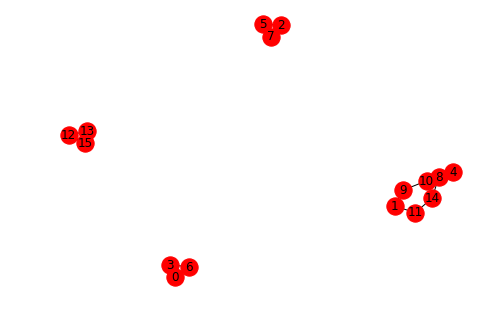

In [36]:
import os
import pyomo.environ as pyo
from pyomo.environ import *

from pyomo.opt import SolverFactory

opt = pyo.SolverFactory('glpk')

model = ConcreteModel()

#
# TSP DV
#
#Xij if we travel from i to j
#
model.X = Var(range(df.shape[0]), range(df.shape[1]), within=Binary, initialize=0)


#
# TSP Objective
#
# Min dij*xij
#
model.obj = Objective(expr = sum([model.X[i,j]*df.iloc[i,j] for i in model.X_index_0.data() for j in model.X_index_1.data()]), 
                      sense=minimize)
model.constraints = ConstraintList()

#
# TSP Constraints
#
# sum_j{xij} = 1 for all i
#
for i in model.X_index_0.data():
    model.constraints.add(sum([model.X[i,j] for j in model.X_index_1.data() if i != j]) ==1)

# sum_i{xij} = 1 for all j
#
for j in model.X_index_1.data():
    model.constraints.add(sum([model.X[i,j] for i in model.X_index_0.data() if i != j]) ==1)

# Remove 2 loops    
for i in model.X_index_0.data():
    for j in model.X_index_1.data():
        model.constraints.add(model.X[i,j] + model.X[j,i] <= 1)

# Create a model instance and optimize
instance = model.create_instance()
results = opt.solve(instance)
#instance.display()

results={}
D = np.zeros((df.shape[0],df.shape[1]), dtype=int)
for k,v in instance.X.get_values().items():
    if v == 1:
        results[k]=v
        D[k[0],k[1]]=1
        #print(k,v)
        
G = nx.from_numpy_matrix(D) 
nx.draw(G, with_labels=True)

#solve_model(plot=True)

# Clearly subtours exist

In [37]:
global model

def add_subtour_constraints2(nodes=[], verbose=False):
    
    tours = list(itertools.permutations(nodes))
    tours = [list(tour) + [tour[0]] for tour in tours]

    if verbose:
        print("Total number of subtours for {} is {}".format(nodes, len(tours)))
        if len(tours) < 8:
            print(tours)
    list_to_sum=[]
    for tour in tours:
        for i in range(len(tour)-1):
            list_to_sum.append(model.X[tour[i],tour[i+1]])
            list_to_sum.append(model.X[tour[i+1],tour[i]])
    print("Constraint added: {}".format(" ".join(['{}+'.format(i) for i in list_to_sum])[:-1] + "<=" + "{}".format(len(tours[0])-1)))
    model.constraints.add(sum(list_to_sum) <= len(tours[0])-1)


def add_subtour_constraints(nodes=[], verbose=False):
    list_to_sum=[]
    #nodes.append(nodes[0])
    for i in nodes:
        for j in nodes:
            list_to_sum.append(model.X[i,j])
            list_to_sum.append(model.X[j,i])
    print("Constraint added: {}".format(" ".join(['{}+'.format(i) for i in list_to_sum])[:-1] + "<=" + "{}".format(len(nodes)-1)))
    model.constraints.add(sum(list_to_sum) <= len(nodes)-1)

def solve_model(plot=False):
    
    # Create a model instance and optimize
    instance = model.create_instance()
    results = opt.solve(instance)
    #instance.display()

    results={}
    D = np.zeros((df.shape[0],df.shape[1]), dtype=int)
    for k,v in instance.X.get_values().items():
        if v == 1:
            results[k]=v
            D[k[0],k[1]]=1
            #print(k,v)

    if plot:
        G = nx.from_numpy_matrix(D) 
        nx.draw(G, with_labels=True)
        
    return D


# (Feasibility Cut 1 -- Eliminate Subtours )

Constraint added: X[6,6]+ X[6,6]+ X[6,0]+ X[0,6]+ X[6,3]+ X[3,6]+ X[0,6]+ X[6,0]+ X[0,0]+ X[0,0]+ X[0,3]+ X[3,0]+ X[3,6]+ X[6,3]+ X[3,0]+ X[0,3]+ X[3,3]+ X[3,3]<=2
Constraint added: X[12,12]+ X[12,12]+ X[12,13]+ X[13,12]+ X[12,15]+ X[15,12]+ X[13,12]+ X[12,13]+ X[13,13]+ X[13,13]+ X[13,15]+ X[15,13]+ X[15,12]+ X[12,15]+ X[15,13]+ X[13,15]+ X[15,15]+ X[15,15]<=2
Constraint added: X[2,2]+ X[2,2]+ X[2,7]+ X[7,2]+ X[2,5]+ X[5,2]+ X[7,2]+ X[2,7]+ X[7,7]+ X[7,7]+ X[7,5]+ X[5,7]+ X[5,2]+ X[2,5]+ X[5,7]+ X[7,5]+ X[5,5]+ X[5,5]<=2
Constraint added: X[1,1]+ X[1,1]+ X[1,11]+ X[11,1]+ X[1,14]+ X[14,1]+ X[1,8]+ X[8,1]+ X[1,4]+ X[4,1]+ X[1,10]+ X[10,1]+ X[1,9]+ X[9,1]+ X[11,1]+ X[1,11]+ X[11,11]+ X[11,11]+ X[11,14]+ X[14,11]+ X[11,8]+ X[8,11]+ X[11,4]+ X[4,11]+ X[11,10]+ X[10,11]+ X[11,9]+ X[9,11]+ X[14,1]+ X[1,14]+ X[14,11]+ X[11,14]+ X[14,14]+ X[14,14]+ X[14,8]+ X[8,14]+ X[14,4]+ X[4,14]+ X[14,10]+ X[10,14]+ X[14,9]+ X[9,14]+ X[8,1]+ X[1,8]+ X[8,11]+ X[11,8]+ X[8,14]+ X[14,8]+ X[8,8]+ X[8,8]+ X[8,

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

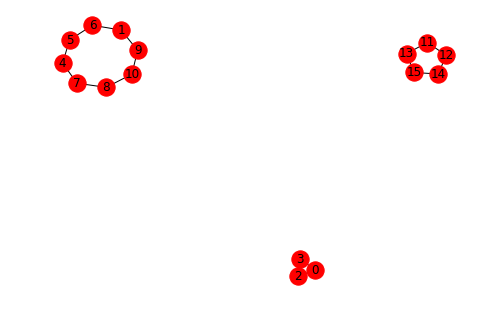

In [38]:
add_subtour_constraints(nodes=[6,0,3], verbose=True)
add_subtour_constraints(nodes=[12,13,15], verbose=True)
add_subtour_constraints(nodes=[2,7,5], verbose=True)
add_subtour_constraints(nodes=[1,11,14,8,4,10,9], verbose=True)

solve_model(plot=True)

# (Feasibility Cut 2)

Constraint added: X[0,0]+ X[0,0]+ X[0,2]+ X[2,0]+ X[0,3]+ X[3,0]+ X[2,0]+ X[0,2]+ X[2,2]+ X[2,2]+ X[2,3]+ X[3,2]+ X[3,0]+ X[0,3]+ X[3,2]+ X[2,3]+ X[3,3]+ X[3,3]<=2
Constraint added: X[12,12]+ X[12,12]+ X[12,14]+ X[14,12]+ X[12,15]+ X[15,12]+ X[12,13]+ X[13,12]+ X[12,11]+ X[11,12]+ X[14,12]+ X[12,14]+ X[14,14]+ X[14,14]+ X[14,15]+ X[15,14]+ X[14,13]+ X[13,14]+ X[14,11]+ X[11,14]+ X[15,12]+ X[12,15]+ X[15,14]+ X[14,15]+ X[15,15]+ X[15,15]+ X[15,13]+ X[13,15]+ X[15,11]+ X[11,15]+ X[13,12]+ X[12,13]+ X[13,14]+ X[14,13]+ X[13,15]+ X[15,13]+ X[13,13]+ X[13,13]+ X[13,11]+ X[11,13]+ X[11,12]+ X[12,11]+ X[11,14]+ X[14,11]+ X[11,15]+ X[15,11]+ X[11,13]+ X[13,11]+ X[11,11]+ X[11,11]<=4
    model; returning a clone of the current model instance.


array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

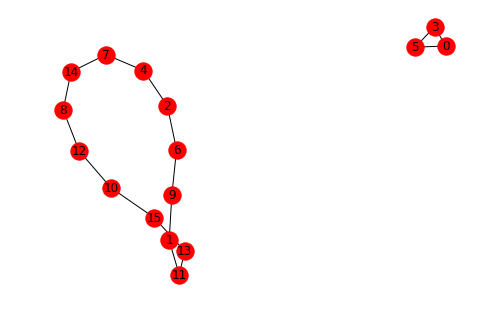

In [39]:
add_subtour_constraints(nodes=[0,2,3], verbose=True)
add_subtour_constraints(nodes=[12,14,15,13,11], verbose=True)

solve_model(plot=True)

# (Feasibility Cut 3)

Constraint added: X[0,0]+ X[0,0]+ X[0,3]+ X[3,0]+ X[0,5]+ X[5,0]+ X[3,0]+ X[0,3]+ X[3,3]+ X[3,3]+ X[3,5]+ X[5,3]+ X[5,0]+ X[0,5]+ X[5,3]+ X[3,5]+ X[5,5]+ X[5,5]<=2
    model; returning a clone of the current model instance.


array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

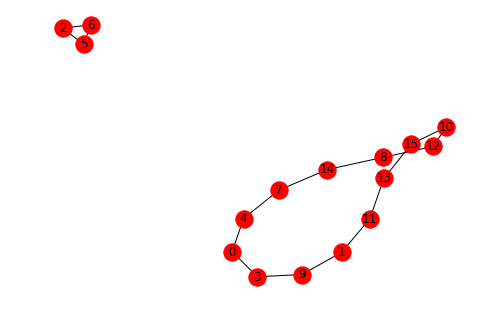

In [40]:
add_subtour_constraints(nodes=[0,3,5], verbose=True)

solve_model(plot=True)

# (Feasibility Cut 4)

Constraint added: X[6,6]+ X[6,6]+ X[6,2]+ X[2,6]+ X[6,5]+ X[5,6]+ X[2,6]+ X[6,2]+ X[2,2]+ X[2,2]+ X[2,5]+ X[5,2]+ X[5,6]+ X[6,5]+ X[5,2]+ X[2,5]+ X[5,5]+ X[5,5]<=2
    model; returning a clone of the current model instance.


array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

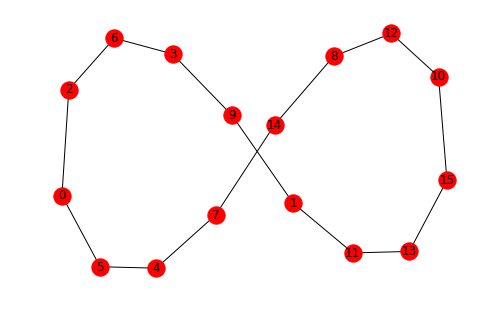

In [41]:
add_subtour_constraints(nodes=[6,2,5], verbose=True)

solve_model(plot=True)

# Final Solution: 6704


## (0,5,4,7,14,8,12,10,15,13,11,1,9,3,6,2,0)


In [43]:
obj = instance.obj
print(obj.display())

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 6704.0
None
